In [1]:
import math
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

sns.reset_defaults()
sns.set_theme(rc={'figure.dpi': 72, 'savefig.dpi': 300,
              'figure.autolayout': True})
sns.set_style('ticks')
sns.set_context('paper')

In [2]:
# Load the graphs

def load_graph(edge_path, name1_path, name2_path=None, largest_cc=True):
    G = nx.read_edgelist(edge_path, nodetype=int, data=False)
    df1 = pd.read_csv(name1_path, names=['id', 'name'], header=None, skiprows=[
                      0], delim_whitespace=True)
    if name2_path is not None:
        df2 = pd.read_csv(name2_path, names=[
                          'name', 'title'], header=None, skiprows=[0])
        df1 = pd.merge(df1, df2, on='name', how='inner')
        df1.rename(columns={'name': 'code', 'title': 'name'}, inplace=True)
    names = {df1.iloc[i]['id']: df1.iloc[i]['name'] for i in range(len(df1))}
    nx.set_node_attributes(G, names, 'name')
    if largest_cc:
        G = G.subgraph(max(nx.connected_components(G), key=len))
    return G


G_airport = load_graph('../datasets/airports.edges',
                       '../datasets/airports.codes', '../datasets/name_of_airports.csv')
G_bible = load_graph('../datasets/bible.edges', '../datasets/bible.names')


In [3]:
# Part a
# Implementation of the centrality metrics

def dsorted(d, reverse=True):
    sorted_keys = sorted(d, key=d.get, reverse=reverse)
    sorted_d = {k: d[k] for k in sorted_keys}
    return sorted_d


def save_dict(d, file_path):
    lines = [f'{k}: {d[k]}\n' for k in d]
    with open(file_path, 'w', encoding='utf-8') as f:
        f.writelines(lines)


def shortest_path(G, src):
    dist = {}
    current_level = 0
    next_level = {src}
    while next_level:
        this_level = next_level
        next_level = set()
        found = []
        for v in this_level:
            if v not in dist:
                dist[v] = current_level
                found.append(v)
        if len(dist) == len(G.nodes):
            return dist
        for v in found:
            next_level.update(G.adj[v])
        current_level += 1
    return dist


def closeness(G):
    centrality = {}
    for u in G.nodes:
        sp = shortest_path(G, u)
        d = sp.values()
        n = len(sp)
        centrality[u] = (n - 1) / sum(d)
    centrality = dsorted(centrality)
    return centrality


def efficiency(G):
    centrality = {}
    for u in G.nodes:
        sp = shortest_path(G, u)
        d = np.array(list(sp.values()))
        d = d[d != 0]
        n = len(sp)
        centrality[u] = (1 / (n - 1)) * np.sum(1 / d)
    centrality = dsorted(centrality)
    return centrality


def degree(G):
    centrality = {}
    for u, k in G.degree():
        n = len(G)
        centrality[u] = k / (n - 1)
    centrality = dsorted(centrality)
    return centrality


def katz(G, alpha=0.1, beta=1.0):
    n = len(G)
    b = np.ones((n, 1)) * beta
    A = nx.to_numpy_matrix(G)
    centrality = np.linalg.solve(np.eye(n, n) - (alpha * A), b)
    norm = np.sign(sum(centrality)) * np.linalg.norm(centrality)
    centrality = dsorted(dict(zip(list(G), map(float, centrality / norm))))
    return centrality


In [4]:
airport_closeness = closeness(G_airport)
airport_efficiency = efficiency(G_airport)
airport_degree = degree(G_airport)
airport_katz = katz(G_airport)

save_dict(airport_closeness, 'airport_closeness.txt')
save_dict(airport_efficiency, 'airport_efficiency.txt')
save_dict(airport_degree, 'airport_degree.txt')
save_dict(airport_katz, 'airport_katz.txt')


bible_closeness = closeness(G_bible)
bible_efficiency = efficiency(G_bible)
bible_degree = degree(G_bible)
bible_katz = katz(G_bible)

save_dict(bible_closeness, 'bible_closeness.txt')
save_dict(bible_efficiency, 'bible_efficiency.txt')
save_dict(bible_degree, 'bible_degree.txt')
save_dict(bible_katz, 'bible_katz.txt')


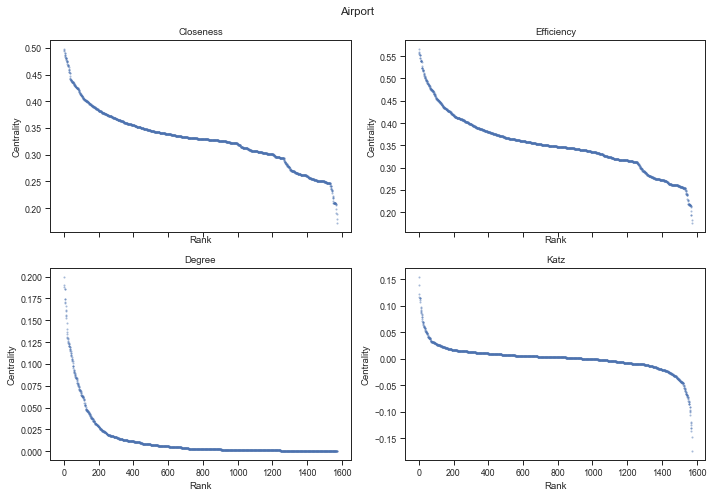

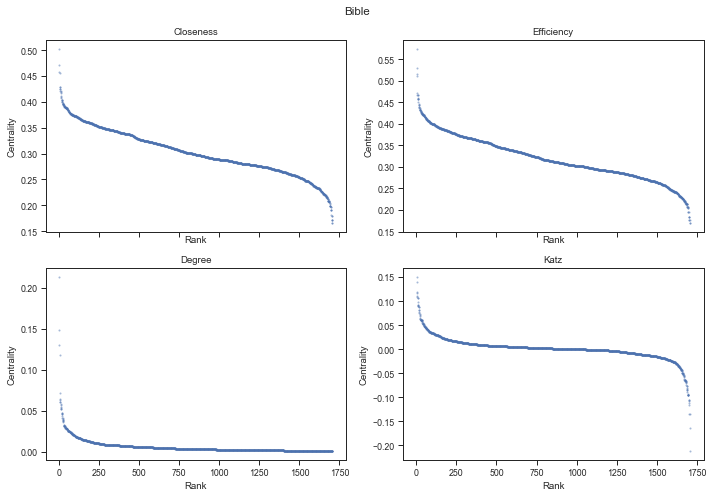

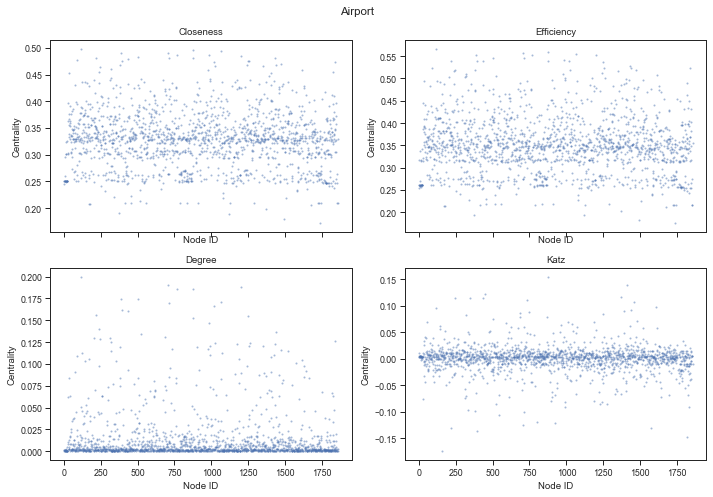

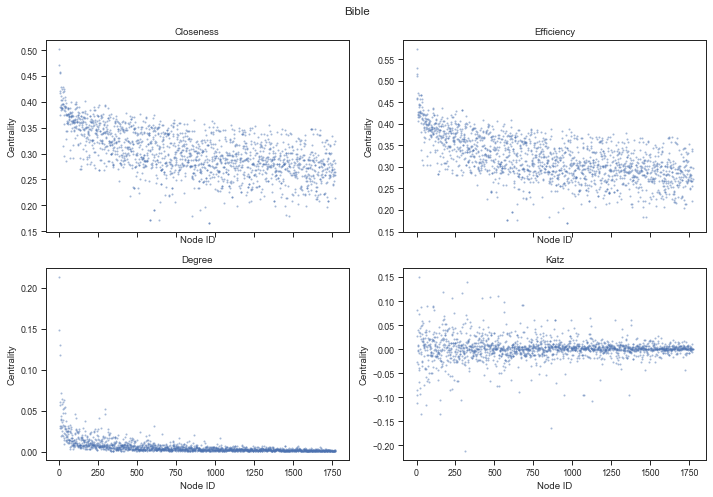

In [37]:
# Part b
# Visualize centralities

def plot_cents(title, cents, type='Rank'):
    name = ('Closeness', 'Efficiency', 'Degree', 'Katz')
    fig, ax = plt.subplots(2, 2, figsize=(10, 7), sharex='all')
    fig.suptitle(title)
    for i, (c, a) in enumerate(zip(cents, ax.flatten())):
        a.set(
            title=name[i],
            xlabel=type,
            ylabel='Centrality',
        )
        x = list(range(1, len(c) + 1)) if type == 'Rank' else c.keys()
        y = c.values()
        sns.scatterplot(x=x, y=y, ax=a, s=4, alpha=0.5, linewidth=0)
    fig.savefig(f'{title.lower()}_{type.lower()}_centralities.png')
    plt.show()


plot_cents(
    'Airport',
    [airport_closeness, airport_efficiency, airport_degree, airport_katz],
    'Rank'
)


plot_cents(
    'Bible',
    [bible_closeness, bible_efficiency, bible_degree, bible_katz],
    'Rank'
)


plot_cents(
    'Airport',
    [airport_closeness, airport_efficiency, airport_degree, airport_katz],
    'Node ID'
)


plot_cents(
    'Bible',
    [bible_closeness, bible_efficiency, bible_degree, bible_katz],
    'Node ID'
)


In [6]:
# Part d
# Generate tables

def gen_table(title, G, cents, n=10):
    header = ['Closeness', 'Efficiency', 'Degree', 'Katz']
    rows = [header]
    for i in range(n):
        row = [0] * 4
        for j in range(4):
            nodes = list(cents[j].keys())[:n]
            values = list(cents[j].values())[:n]
            names = [G.nodes[u]['name'] for u in nodes]
            row[j] = f'{values[i]:.4f} ({names[i]})'
        rows.append(row)
    table = tabulate(rows, headers='firstrow',
                     tablefmt='fancy_grid', floatfmt='.4f')
    print(f"Top Nodes with High Centralities for {title}:")
    print(table, '\n')

    with open(f'{title.lower()}_centralities.csv', 'w', encoding='utf-8') as f:
        for r in rows:
            f.write(','.join(map(lambda x: str(x).replace(',', ''), r)))
            f.write('\n')


gen_table(
    'Airport',
    G_airport,
    [airport_closeness, airport_efficiency, airport_degree, airport_katz]
)

gen_table(
    'Bible',
    G_bible,
    [bible_closeness, bible_efficiency, bible_degree, bible_katz]
)


Top Nodes with High Centralities for Airport:
╒════════════════════════════════════════════════════════════════╤════════════════════════════════════════════════════════════════╤════════════════════════════════════════════════════════════════╤══════════════════════════════════════════════════════════════════════════════╕
│ Closeness                                                      │ Efficiency                                                     │ Degree                                                         │ Katz                                                                         │
╞════════════════════════════════════════════════════════════════╪════════════════════════════════════════════════════════════════╪════════════════════════════════════════════════════════════════╪══════════════════════════════════════════════════════════════════════════════╡
│ 0.4984 (Atlanta, GA: Hartsfield-Jackson Atlanta International) │ 0.5668 (Atlanta, GA: Hartsfield-Jackson Atlanta Internation